In [ ]:
!pip install transformers datasets evaluate tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import collections
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import datasets
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, DefaultDataCollator, create_optimizer
import tensorflow as tf
import evaluate
import json

# Preprocessing

In [ ]:
squad = load_dataset('esakrissa/squad_id_v2')

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130318
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11858
    })
})

In [ ]:
pd_squad_train = pd.DataFrame(squad['train'][:20000])
pd_squad_val = pd.DataFrame(squad['validation'])

In [ ]:
pd_squad_train = pd_squad_train[pd_squad_train.answers != {'text': [], 'answer_start': []}]
pd_squad_val = pd_squad_val[pd_squad_val.answers != {'text': [], 'answer_start': []}]

In [ ]:
len(pd_squad_val)

5928

In [ ]:
dataset_train = Dataset.from_dict(pd_squad_train)

In [ ]:
dataset_val = Dataset.from_dict(pd_squad_val)

In [ ]:
dataset_clean = datasets.DatasetDict({"train":dataset_train,"validation":dataset_val})

squad = dataset_clean

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("esakrissa/IndoBERT-SQuAD")

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/737k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
max_length = 384
stride = 128

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
train_dataset = squad["train"].map(preprocess_training_examples, batched=True, remove_columns=squad["train"].column_names)

  0%|          | 0/15 [00:00<?, ?ba/s]

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 14614
})

In [ ]:
def preprocess_validation_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
validation_dataset = squad['validation'].map(preprocess_validation_function, batched=True, remove_columns=squad["validation"].column_names)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
small_eval_set = squad["validation"].select(range(100))
eval_set = small_eval_set.map(preprocess_validation_function, batched=True, remove_columns=squad["validation"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 6032
})

In [ ]:
eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("numpy")

batch = {k: eval_set_for_model[k] for k in eval_set_for_model.column_names}
trained_model = TFAutoModelForQuestionAnswering.from_pretrained("esakrissa/IndoBERT-SQuAD", from_pt=True)

outputs = trained_model(**batch)

Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [ ]:
start_logits = outputs.start_logits.numpy()
end_logits = outputs.end_logits.numpy()

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -20 - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -20 - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > 30
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
metric = evaluate.load("squad")

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained("esakrissa/IndoBERT-SQuAD", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [ ]:
tf_train_dataset = model.prepare_tf_dataset(train_dataset, collate_fn=data_collator, shuffle=True, batch_size=4)
tf_eval_dataset = model.prepare_tf_dataset(validation_dataset, collate_fn=data_collator, shuffle=False, batch_size=4)

In [ ]:
len(tf_train_dataset)

3653

In [ ]:
num_train_epochs = 20
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-05,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history = model.fit(tf_train_dataset, epochs=num_train_epochs, validation_data=tf_eval_dataset,  validation_steps=1)

Epoch 1/20
3653/3653 [==============================] - 218s 56ms/step - loss: 0.9927 - end_logits_accuracy: 0.7321 - start_logits_accuracy: 0.7113 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 2/20
3653/3653 [==============================] - 199s 54ms/step - loss: 0.6436 - end_logits_accuracy: 0.8104 - start_logits_accuracy: 0.8017 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 3/20
3653/3653 [==============================] - 199s 54ms/step - loss: 0.4689 - end_logits_accuracy: 0.8536 - start_logits_accuracy: 0.8492 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 4/20
3653/3653 [==============================] - 200s 55ms/step - loss: 0.3400 - end_logits_accuracy: 0.8926 - start_logits_accuracy: 0.8908 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoc

In [ ]:
model.evaluate(tf_train_dataset)

3653/3653 [==============================] - 54s 14ms/step - loss: 0.0016 - end_logits_accuracy: 0.9992 - start_logits_accuracy: 0.9995


[0.0016043720534071326, 0.9991787672042847, 0.999452531337738]

In [ ]:
predictions = model.predict(tf_eval_dataset)
f1_score = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    squad["validation"],
)



1508/1508 [==============================] - 78s 50ms/step


  0%|          | 0/5928 [00:00<?, ?it/s]

In [ ]:
f1_score

{'exact_match': 57.776653171390016, 'f1': 73.96658553465217}

In [ ]:
from transformers import pipeline

qa_pipeline = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer
)
qa_pipeline({
    'context': """Sudah sejak tahun 1920-an, Ubud terkenal di antara wisatawan barat. Kala itu pelukis Jerman; Walter Spies dan pelukis Belanda; Rudolf Bonnet menetap di sana. Mereka dibantu oleh Tjokorda Gde Agung Sukawati, dari Puri Agung Ubud. Sekarang karya mereka bisa dilihat di Museum Puri Lukisan, Ubud.""",
    'question': "Sejak kapan Ubud terkenal di antara wisatawan barat?"
})

{'score': 0.9999994039535522, 'start': 18, 'end': 25, 'answer': '1920-an'}

In [ ]:
model.save_weights('/content/model/model', save_format='tf')

In [ ]:
load_model = TFAutoModelForQuestionAnswering.from_pretrained("esakrissa/IndoBERT-SQuAD", from_pt=True)
load_model.compile(optimizer=optimizer, metrics=['accuracy'])
load_model.load_weights('/content/model/model')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a com

In [ ]:
from transformers import pipeline

qa_pipeline = pipeline(
    "question-answering",
    model=load_model,
    tokenizer=tokenizer
)
qa_pipeline({
    'context': """Sudah sejak tahun 1920-an, Ubud terkenal di antara wisatawan barat. Kala itu pelukis Jerman; Walter Spies dan pelukis Belanda; Rudolf Bonnet menetap di sana. Mereka dibantu oleh Tjokorda Gde Agung Sukawati, dari Puri Agung Ubud. Sekarang karya mereka bisa dilihat di Museum Puri Lukisan, Ubud.""",
    'question': "Sejak kapan Ubud terkenal di antara wisatawan barat?"
})

In [ ]:
load_model.evaluate(tf_train_dataset)

3653/3653 [==============================] - 55s 14ms/step - loss: 0.0016 - end_logits_accuracy: 0.9992 - start_logits_accuracy: 0.9995


[0.0016043696086853743, 0.9991787672042847, 0.999452531337738]

In [ ]:
with open('/content/model/history.json','w') as h:
  json.dump(history.history, h)

with open('/content/model/f1_score.json','w') as h:
  json.dump(f1_score, h)


with open('/content/model/history.json', 'r') as h:
  history = json.load(h)


with open('/content/model/f1_score.json', 'r') as h:
  score = json.load(h)


In [ ]:
history

{'loss': [0.992703378200531,
  0.6436030864715576,
  0.468938410282135,
  0.3400147557258606,
  0.24384121596813202,
  0.1910281479358673,
  0.15412849187850952,
  0.11386275291442871,
  0.09990604966878891,
  0.08461251109838486,
  0.06414785236120224,
  0.06633912026882172,
  0.05019211024045944,
  0.039645373821258545,
  0.031526997685432434,
  0.02402651682496071,
  0.01929721236228943,
  0.015669815242290497,
  0.011408142745494843,
  0.00804391223937273],
 'end_logits_accuracy': [0.7320695519447327,
  0.8104298114776611,
  0.8536134958267212,
  0.8926225304603577,
  0.9180810451507568,
  0.935258686542511,
  0.9488092064857483,
  0.9608541131019592,
  0.9657130837440491,
  0.9709827303886414,
  0.9773473739624023,
  0.9744045734405518,
  0.9820010662078857,
  0.9869285225868225,
  0.9896660447120667,
  0.9921981692314148,
  0.9930194616317749,
  0.9944565892219543,
  0.9959622025489807,
  0.9976047277450562],
 'start_logits_accuracy': [0.7112647294998169,
  0.8016698360443115,
  

In [ ]:
score

{'exact_match': 57.776653171390016, 'f1': 73.96658553465217}

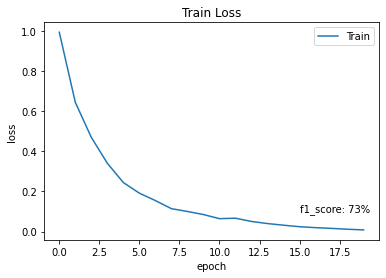

In [ ]:
from matplotlib import pyplot

pyplot.title('Train Loss')
pyplot.plot(history['loss'], label="Train")
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.text(15, 0.1, "f1_score: "+str(int(score['f1']))+"%")
pyplot.legend()
pyplot.show()

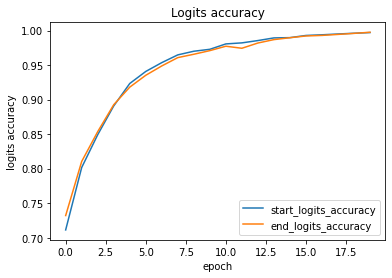

In [ ]:
pyplot.title('Logits accuracy')
pyplot.xlabel("epoch")
pyplot.ylabel("logits accuracy")
pyplot.plot(history['start_logits_accuracy'], label='start_logits_accuracy')
pyplot.plot(history['end_logits_accuracy'], label='end_logits_accuracy')
pyplot.legend()
pyplot.show()

# 2nd test

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained("esakrissa/IndoBERT-SQuAD", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [ ]:
num_train_epochs = 20
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=1e-05,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    
)
model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history_2 = model.fit(tf_train_dataset, epochs=num_train_epochs, validation_data=tf_eval_dataset,  validation_steps=1)

Epoch 1/20
3653/3653 [==============================] - 214s 56ms/step - loss: 0.8787 - end_logits_accuracy: 0.7546 - start_logits_accuracy: 0.7379 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 2/20
3653/3653 [==============================] - 200s 55ms/step - loss: 0.6408 - end_logits_accuracy: 0.8080 - start_logits_accuracy: 0.8027 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 3/20
3653/3653 [==============================] - 200s 55ms/step - loss: 0.4691 - end_logits_accuracy: 0.8536 - start_logits_accuracy: 0.8464 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 4/20
3653/3653 [==============================] - 201s 55ms/step - loss: 0.3880 - end_logits_accuracy: 0.8726 - start_logits_accuracy: 0.8765 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoc

In [ ]:
model.evaluate(tf_train_dataset)

3653/3653 [==============================] - 54s 14ms/step - loss: 0.0040 - end_logits_accuracy: 0.9977 - start_logits_accuracy: 0.9993


[0.0040185353718698025, 0.9977415800094604, 0.999315619468689]

In [ ]:
predictions = model.predict(tf_eval_dataset)
f1_score_2 = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    squad["validation"],
)

1508/1508 [==============================] - 79s 50ms/step


  0%|          | 0/5928 [00:00<?, ?it/s]

In [ ]:
model.save_weights('/content/model/model_2', save_format='tf')

In [ ]:
with open('/content/model/history_2.json','w') as h:
  json.dump(history_2.history, h)

with open('/content/model/f1_score_2.json','w') as h:
  json.dump(f1_score_2, h)


with open('/content/model/history_2.json', 'r') as h:
  history_2 = json.load(h)


with open('/content/model/f1_score_2.json', 'r') as h:
  score_2 = json.load(h)



In [ ]:
history_2

{'loss': [0.8787098526954651,
  0.6408083438873291,
  0.4691465497016907,
  0.3880102038383484,
  0.27079761028289795,
  0.20627634227275848,
  0.18501874804496765,
  0.1373259723186493,
  0.11000113934278488,
  0.08878952264785767,
  0.07592793554067612,
  0.06520234048366547,
  0.05754147469997406,
  0.043999083340168,
  0.041973892599344254,
  0.03394949063658714,
  0.028046665713191032,
  0.026270361617207527,
  0.023578468710184097,
  0.02057022601366043],
 'end_logits_accuracy': [0.7545852661132812,
  0.8079660534858704,
  0.8536134958267212,
  0.8725705146789551,
  0.9058308005332947,
  0.9313578009605408,
  0.9351218342781067,
  0.9527785181999207,
  0.9605119228363037,
  0.968245267868042,
  0.9744730591773987,
  0.9750889539718628,
  0.9786477088928223,
  0.9845332503318787,
  0.9843279719352722,
  0.9871338605880737,
  0.990487277507782,
  0.9906925559043884,
  0.991719126701355,
  0.9917875528335571],
 'start_logits_accuracy': [0.7378866672515869,
  0.8026964068412781,
  0.

In [ ]:
score_2

{'exact_match': 59.008097165991906, 'f1': 75.36730678963954}

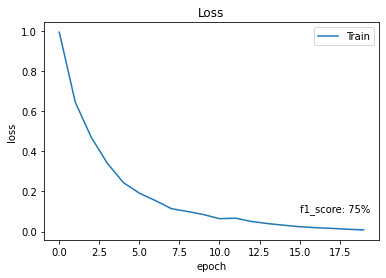

In [ ]:
from matplotlib import pyplot

pyplot.title('Loss')
pyplot.plot(history['loss'], label='Train')
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.text(15, 0.1, "f1_score: "+str(int(score_2['f1']))+"%")
pyplot.legend()
pyplot.show()

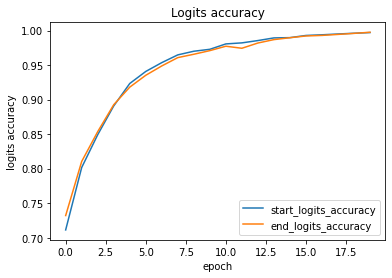

In [ ]:
pyplot.title('Logits accuracy')
pyplot.xlabel("epoch")
pyplot.ylabel("logits accuracy")
pyplot.plot(history['start_logits_accuracy'], label='start_logits_accuracy')
pyplot.plot(history['end_logits_accuracy'], label='end_logits_accuracy')
pyplot.legend()
pyplot.show()

In [ ]:
from transformers import pipeline

qa_pipeline = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer
)
qa_pipeline({
    'context': """Sudah sejak tahun 1920-an, Ubud terkenal di antara wisatawan barat. Kala itu pelukis Jerman; Walter Spies dan pelukis Belanda; Rudolf Bonnet menetap di sana. Mereka dibantu oleh Tjokorda Gde Agung Sukawati, dari Puri Agung Ubud. Sekarang karya mereka bisa dilihat di Museum Puri Lukisan, Ubud.""",
    'question': "Sejak kapan Ubud terkenal di antara wisatawan barat?"
})

{'score': 0.9948574304580688, 'start': 18, 'end': 25, 'answer': '1920-an'}

In [ ]:
from google.colab import files

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(train_dataset, collate_fn=data_collator, shuffle=True, batch_size=16)
tf_eval_dataset = model.prepare_tf_dataset(validation_dataset, collate_fn=data_collator, shuffle=False, batch_size=16)

In [ ]:
num_train_epochs = 20
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-05,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history_3 = model.fit(tf_train_dataset, epochs=num_train_epochs, validation_data=tf_eval_dataset,  validation_steps=1)

Epoch 1/20
913/913 [==============================] - 163s 163ms/step - loss: 0.8762 - end_logits_accuracy: 0.7597 - start_logits_accuracy: 0.7410 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 2/20
913/913 [==============================] - 146s 160ms/step - loss: 0.6686 - end_logits_accuracy: 0.8037 - start_logits_accuracy: 0.7932 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 3/20
913/913 [==============================] - 146s 160ms/step - loss: 0.5093 - end_logits_accuracy: 0.8432 - start_logits_accuracy: 0.8349 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 4/20
913/913 [==============================] - 146s 160ms/step - loss: 0.3766 - end_logits_accuracy: 0.8737 - start_logits_accuracy: 0.8763 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 5/

In [ ]:
model.evaluate(tf_train_dataset)

913/913 [==============================] - 45s 48ms/step - loss: 0.0045 - end_logits_accuracy: 0.9980 - start_logits_accuracy: 0.9994


[0.004505337215960026, 0.9980148077011108, 0.9993839263916016]

In [ ]:
predictions = model.predict(tf_eval_dataset)
f1_score_3 = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    squad["validation"],
)

377/377 [==============================] - 32s 75ms/step


  0%|          | 0/5928 [00:00<?, ?it/s]

In [ ]:
model.save_weights('/content/model/model_3', save_format='tf')

In [ ]:
with open('/content/model/history_3.json','w') as h:
  json.dump(history_3.history, h)

with open('/content/model/f1_score_3.json','w') as h:
  json.dump(f1_score_3, h)


with open('/content/model/history_3.json', 'r') as h:
  history_3 = json.load(h)


with open('/content/model/f1_score_3.json', 'r') as h:
  score_3 = json.load(h)


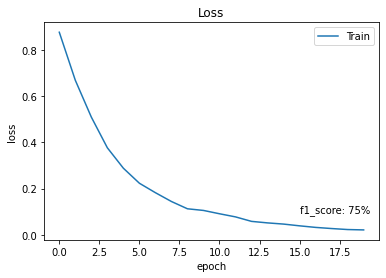

In [ ]:
from matplotlib import pyplot

pyplot.title('Loss')
pyplot.plot(history_3['loss'], label='Train')
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.text(15, 0.1, "f1_score: "+str(int(score_3['f1']))+"%")
pyplot.legend()
pyplot.show()

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained("esakrissa/IndoBERT-SQuAD", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [ ]:
num_train_epochs = 20
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=1e-05,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history_4 = model.fit(tf_train_dataset, epochs=num_train_epochs, validation_data=tf_eval_dataset,  validation_steps=1)

Epoch 1/20
913/913 [==============================] - 158s 162ms/step - loss: 0.8438 - end_logits_accuracy: 0.7648 - start_logits_accuracy: 0.7484 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 2/20
913/913 [==============================] - 146s 160ms/step - loss: 0.6534 - end_logits_accuracy: 0.8072 - start_logits_accuracy: 0.7939 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 3/20
913/913 [==============================] - 146s 160ms/step - loss: 0.5583 - end_logits_accuracy: 0.8277 - start_logits_accuracy: 0.8226 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 4/20
913/913 [==============================] - 146s 160ms/step - loss: 0.4778 - end_logits_accuracy: 0.8495 - start_logits_accuracy: 0.8452 - val_loss: 0.0000e+00 - val_end_logits_accuracy: 0.0000e+00 - val_start_logits_accuracy: 0.0000e+00
Epoch 5/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.evaluate(tf_train_dataset)

913/913 [==============================] - 45s 47ms/step - loss: 0.0166 - end_logits_accuracy: 0.9955 - start_logits_accuracy: 0.9976


[0.01662086881697178, 0.9954819083213806, 0.9976040720939636]

In [ ]:
predictions = model.predict(tf_eval_dataset)
f1_score_4 = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    squad["validation"],
)

377/377 [==============================] - 30s 73ms/step


  0%|          | 0/5928 [00:00<?, ?it/s]

In [ ]:
model.save_weights('/content/model/model_4', save_format='tf')

In [ ]:
with open('/content/model/history_4.json','w') as h:
  json.dump(history_4.history, h)

with open('/content/model/f1_score_4.json','w') as h:
  json.dump(f1_score_4, h)


with open('/content/model/history_4.json', 'r') as h:
  history_4 = json.load(h)


with open('/content/model/f1_score_4.json', 'r') as h:
  score_4 = json.load(h)


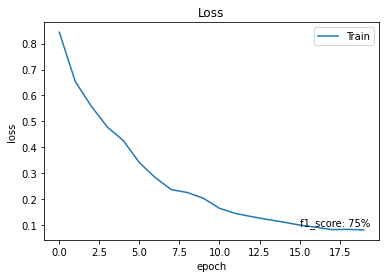

In [ ]:
from matplotlib import pyplot

pyplot.title('Loss')
pyplot.plot(history_4['loss'], label='Train')
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.text(15, 0.1, "f1_score: "+str(int(score_4['f1']))+"%")
pyplot.legend()
pyplot.show()